# Exploratory Data Analysis (EDA) 🤓 📉

### From "About" page:

This challenge leverages four provided CSV datasets containing network performance metrics for 2,880 beams across 30 base stations. Each base station consists of 3 cells with 32 beams, with data recorded hourly. These datasets encompass a five-week period with data recorded at hourly intervals (as illustrated in Figure 2). These datasets are traffic_DLThpVol.csv, traffic_DLThpTime.csv, traffic_MR_number.csv, and traffic_DLPRB.csv. We remind the participants that the objective is to forecast future values of traffic volume (DLThpVol).

Each dataset corresponds to a specific network performance metric:

    traffic_DLThpVol.csv: represents throughput volume.
    traffic_DLThpTime.csv: represents throughput time.
    traffic_ DLPRB.csv: represents Physical Resource Block (PRB) utilization.
    traffic_MR_number.csv: represents user count.

### Key takeaways:

Every CSV has:

*   840 rows, representing hours in the observation period
*   2880 cols, representing beams (2880 total beams = 30 base stations * 3 cells per base station * 32 beams per cell), which have names 'station_cell_beam', e.g. 0_1_20 for 21st beam of second cell of first station

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pathlib import Path

np.random.seed(42)

In [3]:
np.random.seed(42)

input_dir = Path('input-data')
traffic_dlthpvol = pd.read_csv(input_dir / "traffic_DLThpVol.csv", index_col=0)
traffic_mr = pd.read_csv(input_dir / "traffic_MR_number.csv", index_col=0)
traffic_dlthptime = pd.read_csv(input_dir / "traffic_DLThpTime.csv", index_col=0)
traffic_dlprb = pd.read_csv(input_dir / "traffic_DLPRB.csv", index_col=0)

dfs = [traffic_dlthpvol, traffic_mr, traffic_dlthptime, traffic_dlprb]

In [4]:
traffic_mr.name = "User Count (Traffic MR Number)"
traffic_dlthpvol.name = "Throughput Volume"
traffic_dlthptime.name = "Throughput Time"
traffic_dlprb.name = "Physical Resource Block Utilization"

In [5]:
# Extract unique identifiers from column names
def extract_identifiers(df):
  identifiers = list()
  for col in df.columns:
    parts = col.split('_')
    parts = [int(part) for part in parts]
    identifiers.append(parts)
  return identifiers

def create_multiindex(df: pd.DataFrame):
  identifiers = extract_identifiers(df)
  return pd.MultiIndex.from_tuples(identifiers, names=['station', 'cell', 'beam'])

for df in dfs:
  df.columns = create_multiindex(df)

In [6]:
for df in dfs:
  print(f"{df.name} SHAPE: {df.shape}")

Throughput Volume SHAPE: (840, 2880)
User Count (Traffic MR Number) SHAPE: (840, 2880)
Throughput Time SHAPE: (840, 2880)
Physical Resource Block Utilization SHAPE: (840, 2880)


In [7]:
# Some elements
print("\nTraffic MR head:\n", traffic_mr.iloc[:7, :7])


Traffic MR head:
 station         0                                                            
cell            0                                                            
beam            0         1         2         3         4         5         6
0        0.000000  0.000000  0.000000  0.027642  0.055997  0.000000  0.000000
1        0.000000  0.152042  0.000000  0.000000  0.000000  0.000000  0.010041
2        0.173515  0.227844  0.000000  0.007925  0.000000  0.000000  0.056169
3        0.000000  0.000000  0.030259  0.010449  0.098800  0.000000  0.000000
4        0.062068  0.000000  0.179430  0.000000  0.184392  0.000000  0.244443
5        0.186170  0.000000  0.197342  0.000000  0.059711  0.258401  0.135679
6        0.024714  0.153375  0.338520  0.000000  0.100804  0.091781  0.000000


## One cell through time

In [8]:
cell_idx = 1050

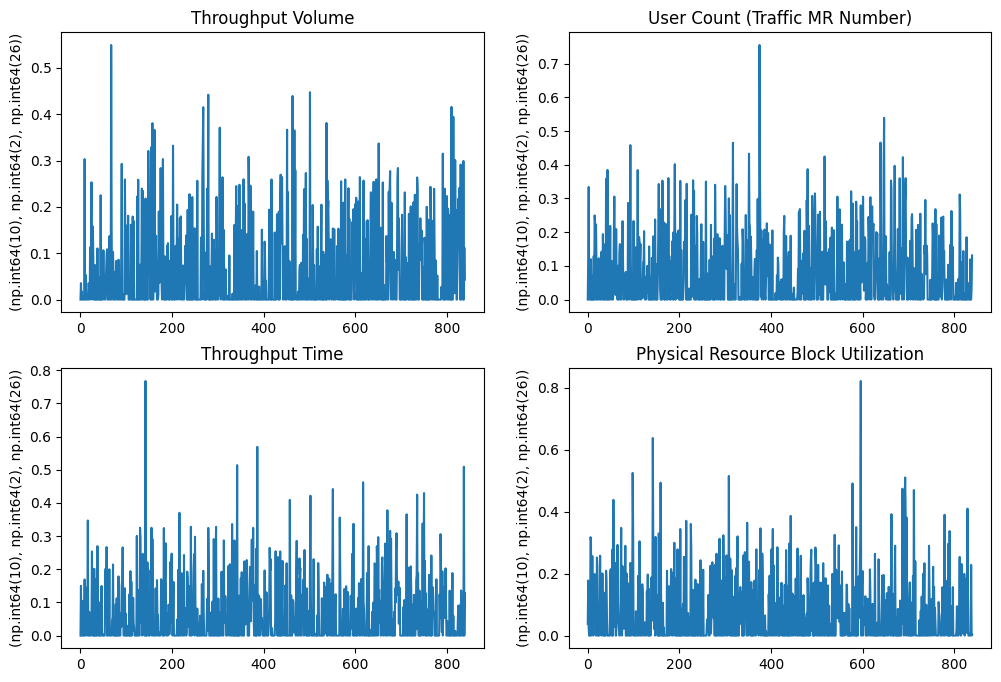

In [9]:
# Make it elegant with a loop for the plots
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, df in enumerate(dfs):
  sns.lineplot(data=df.iloc[:, cell_idx], ax=axes[i // 2, i % 2])
  axes[i // 2, i % 2].set_title(df.name)

User Counts (Traffic MR) are not integers. Have all the time series been normalized somehow? How?

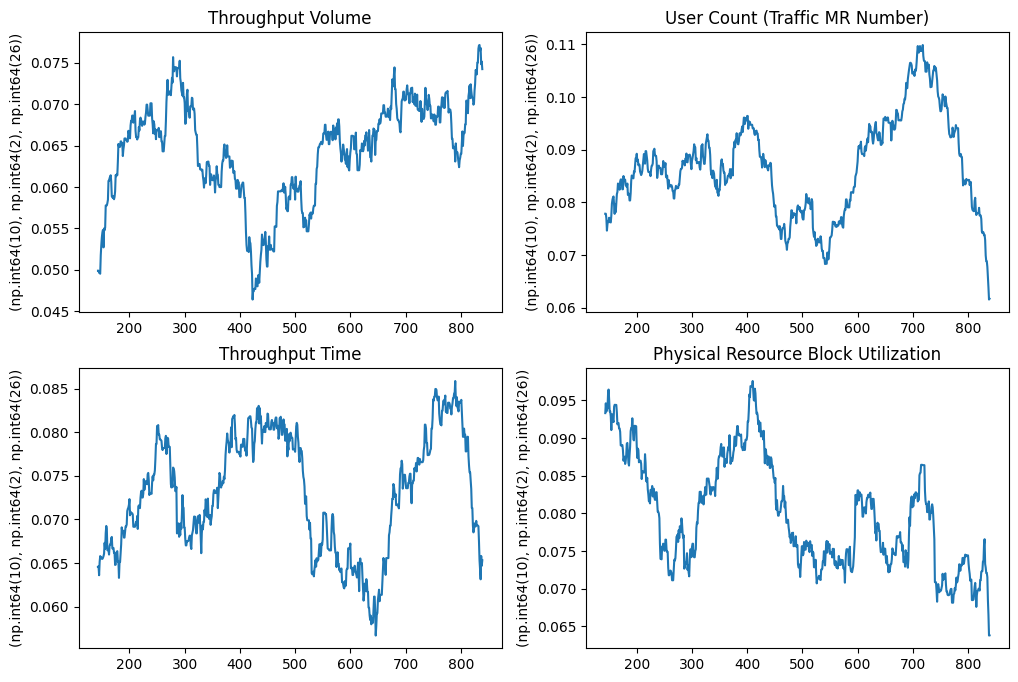

In [10]:
# Rolling averages (24h)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, df in enumerate(dfs):
  rolling_avg = df.iloc[:, cell_idx].rolling(window=144).mean()
  sns.lineplot(data=rolling_avg, ax=axes[i // 2, i % 2])
  axes[i // 2, i % 2].set_title(df.name)

Text(0.5, 1.0, 'Throughput Volume / PRB Utilization')

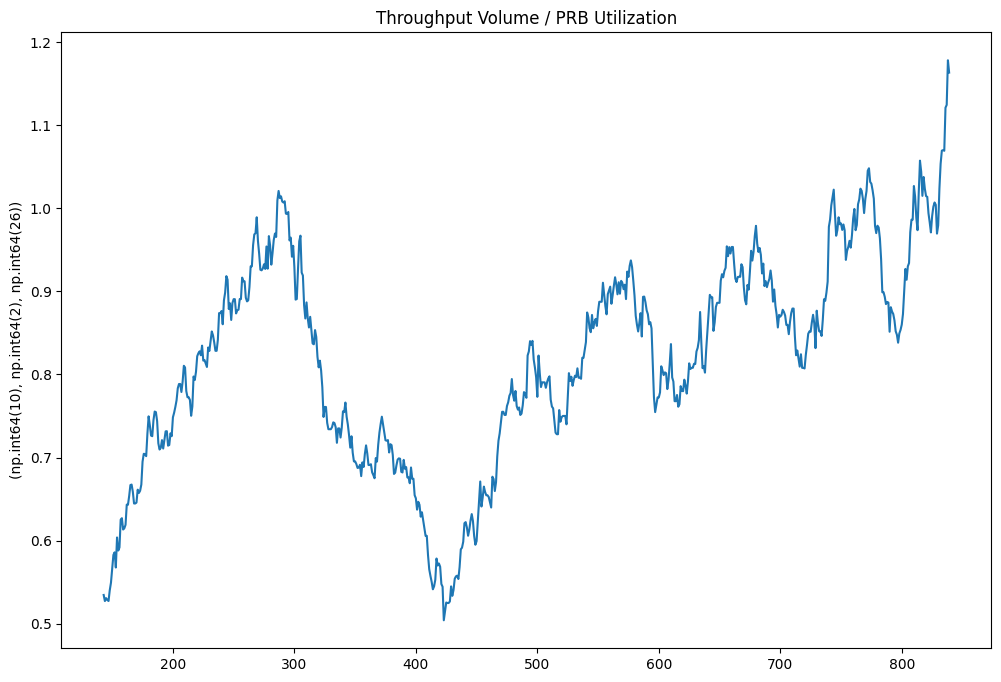

In [11]:
# Volume divided by PRB (plus epsilon to avoid division by zero)
# Both as rolling mean
vol = traffic_dlthpvol.iloc[:, cell_idx].rolling(window=144).mean()
prb = traffic_dlprb.iloc[:, cell_idx].rolling(window=144).mean()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=vol / (prb + 1e-6), ax=ax)
ax.set_title("Throughput Volume / PRB Utilization")

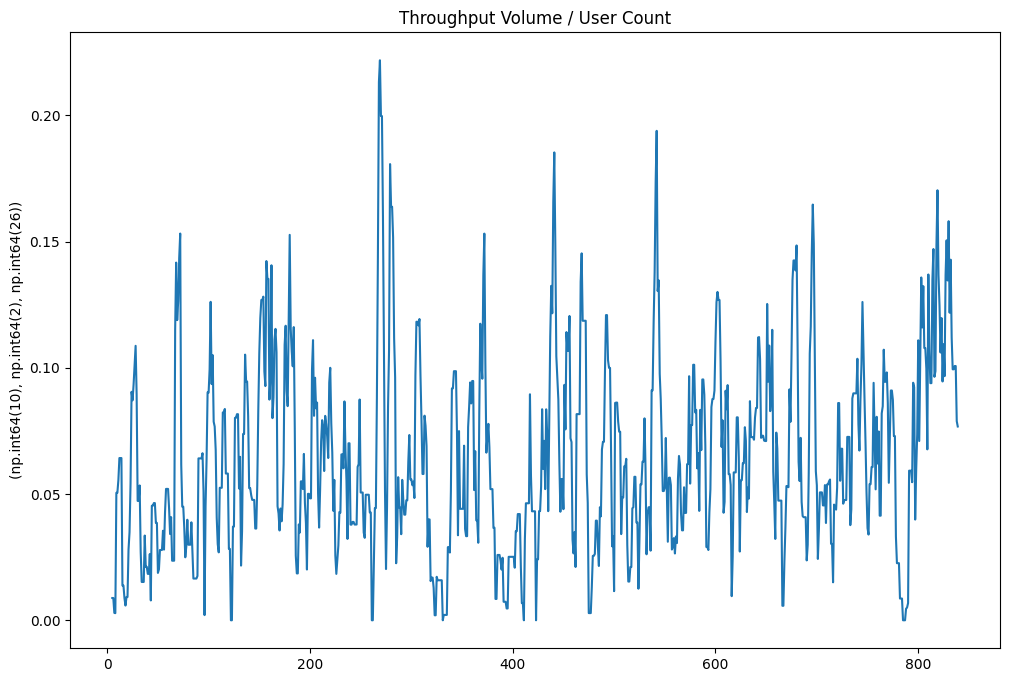

In [26]:
## Volume divided by MR (User Count)
vol = traffic_dlthpvol.iloc[:, cell_idx].rolling(window=6).mean()
mr = traffic_mr.iloc[:, cell_idx].rolling(window=6).mean()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=vol, ax=ax)
ax.set_title("Throughput Volume / User Count")

plt.show()

## Aggregating over individual time series

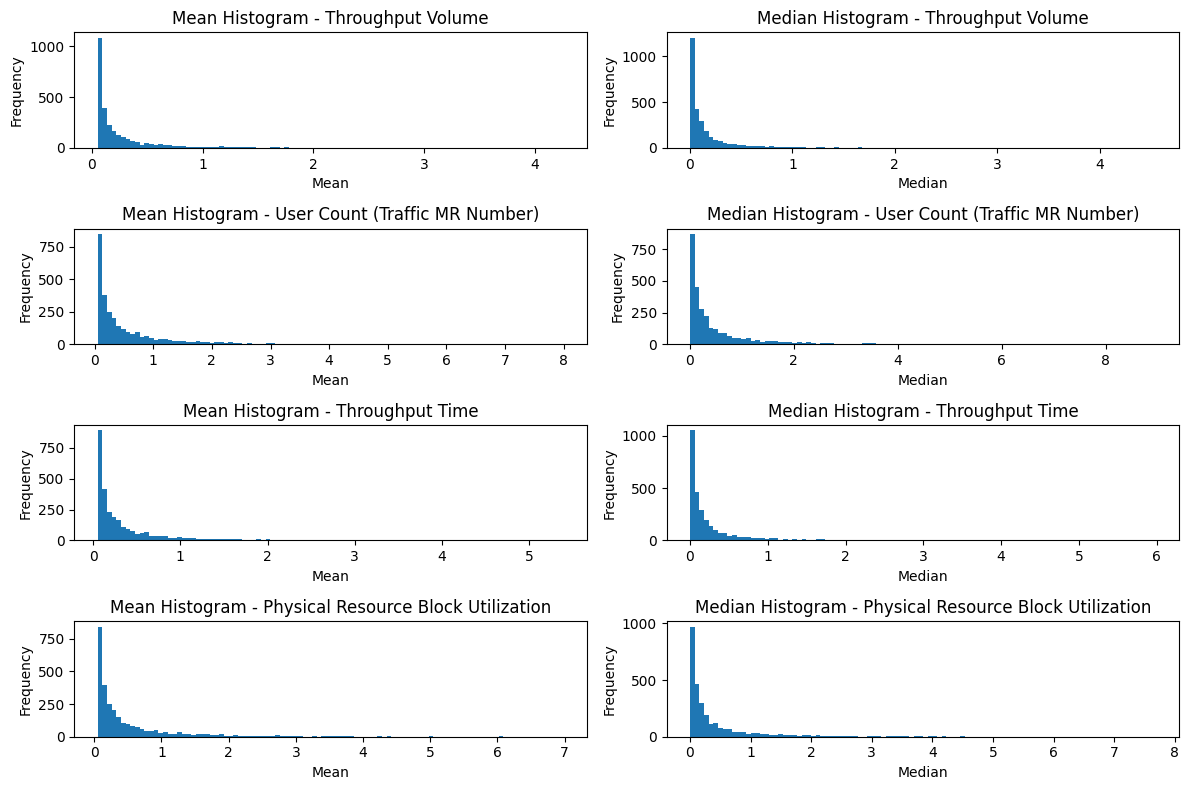

In [13]:
# Calculate means and medians for each dataframe
means = []
medians = []

for df in dfs:
    means.append(df.mean())
    medians.append(df.median())

# Create histograms for each dataframe, with small buckets
fig, axes = plt.subplots(len(dfs), 2, figsize=(12, 8))

for i, (df, mean, median) in enumerate(zip(dfs, means, medians)):
    ax1 = axes[i, 0]
    ax2 = axes[i, 1]
    
    # Plot histogram of means
    ax1.hist(mean, bins=100)
    ax1.set_title(f"Mean Histogram - {df.name}")
    ax1.set_xlabel("Mean")
    ax1.set_ylabel("Frequency")
    
    # Plot histogram of medians
    ax2.hist(median, bins=100)
    ax2.set_title(f"Median Histogram - {df.name}")
    ax2.set_xlabel("Median")
    ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

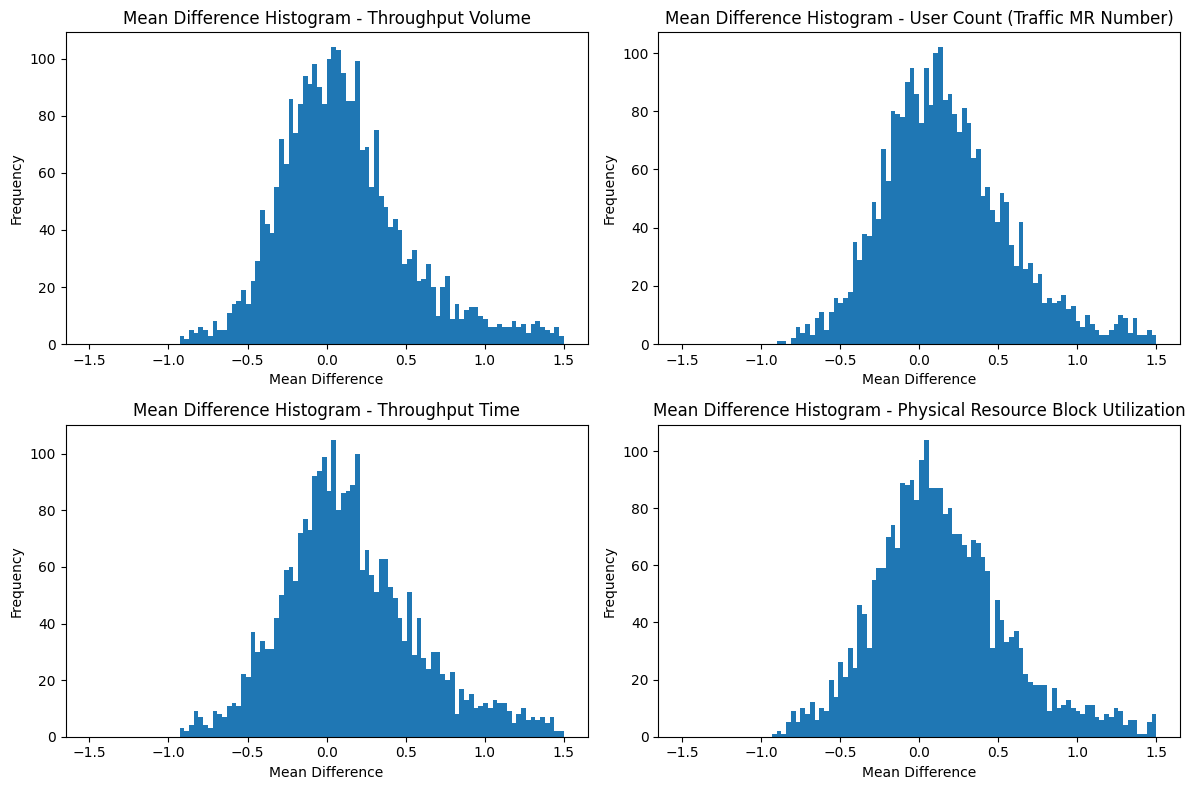

In [14]:
# For every beam, calculate the mean of the first 72 hrs and the last 72 hrs, and get the difference of that divided by the mean of the first 24 hrs
beam_means = []
beam_diffs = []

for df in dfs:
    beam_means.append(df.mean())
    
    first_72 = df.iloc[:72].mean()
    last_72 = df.iloc[-72:].mean()
    diff = (last_72 - first_72) / first_72
    beam_diffs.append(diff)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, (df, beam_mean, beam_diff) in enumerate(zip(dfs, beam_means, beam_diffs)):
    ax1 = axes[i // 2, i % 2]
    
    # Plot histogram of means ending at 1
    ax1.hist(beam_diff, bins=100, range=(-1.5, 1.5))
    ax1.set_title(f"Mean Difference Histogram - {df.name}")
    ax1.set_xlabel("Mean Difference")
    ax1.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Number of zero entries

There is about 30 % zero entries on average

In [15]:
# In each df, count number of zeroes in each of the 2880 time series and give summary stats

def count_zeroes_and_describe(df: pd.DataFrame):
  zero_counts = (df == 0).sum(axis=1) / df.shape[1] * 100
  return zero_counts.describe()

for df in [traffic_dlthpvol]:
  print(f"\nPERCENTAGE OF ZEROES {df.name}:\n", count_zeroes_and_describe(df))


PERCENTAGE OF ZEROES Throughput Volume:
 count    840.000000
mean      31.760127
std        6.051990
min       24.236111
25%       27.144097
50%       29.131944
75%       36.241319
max       50.798611
dtype: float64


### Correlations between beam pairs in the same cell, same station and arbitary cell pairs

We should maybe factor these into our model somehow.

Mean correlation between...
* arbitrary pair of beams: 0.035
* two beams in the same station: 0.049
* two beams in the same cell: 0.061

In [16]:
station_correlations = {}
for station in traffic_dlthpvol.columns.get_level_values('station').unique():
    station_data = traffic_dlthpvol.loc[:, station]
    station_correlations[station] = station_data.corr()

# station_correlations[1]

mean_station_correlations = {}
for station, corr_matrix in station_correlations.items():
    mean_station_correlations[station] = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean()

mean_station_correlations = np.array(list(mean_station_correlations.values()))
print("Mean station mean correlation:", mean_station_correlations.mean())
print("Median station mean correlation:", np.median(mean_station_correlations))
print("Standard deviation of station mean correlations:", mean_station_correlations.std())
print("Minimum station mean correlation:", mean_station_correlations.min())
print("Maximum station mean correlation:", mean_station_correlations.max())

Mean station mean correlation: 0.04944600906587727
Median station mean correlation: 0.05163662364700153
Standard deviation of station mean correlations: 0.025727672226003386
Minimum station mean correlation: 0.004141165277136118
Maximum station mean correlation: 0.09168422837864641


In [17]:
cell_correlations = {}
for station in traffic_dlthpvol.columns.get_level_values('station').unique():
    station_data = traffic_dlthpvol.loc[:, station]
    for cell in station_data.columns.get_level_values('cell').unique():
        cell_data = station_data.loc[:, cell]
        cell_correlations[(station, cell)] = cell_data.corr()

# print(cell_correlations[(2,2)])

mean_cell_correlations = {}
for cell, corr_matrix in cell_correlations.items():
   mean_cell_correlations[cell] = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean()

mean_cell_correlations = np.array(list(mean_cell_correlations.values()))
print("Mean cell mean correlation:", mean_cell_correlations.mean())
print("Median cell mean correlation:", np.median(mean_cell_correlations))
print("Standard deviation of cell mean correlations:", mean_cell_correlations.std())
print("Minimum cell mean correlation:", mean_cell_correlations.min())
print("Maximum cell mean correlation:", mean_cell_correlations.max())

Mean cell mean correlation: 0.06050580640230319
Median cell mean correlation: 0.051095745331808703
Standard deviation of cell mean correlations: 0.042749605882591746
Minimum cell mean correlation: 0.0018655420748393654
Maximum cell mean correlation: 0.1684931390595539


In [18]:
# Select 100 random beams
random_beams = np.random.choice(traffic_dlthpvol.columns, size=200, replace=False)

# Calculate correlations
random_beam_correlations = traffic_dlthpvol[random_beams].corr()

# Calculate mean, median, etc.
correlation_summary = random_beam_correlations.values[np.triu_indices_from(random_beam_correlations.values, k=1)]
print("Mean correlation:", correlation_summary.mean())
print("Median correlation:", np.median(correlation_summary))
print("Standard deviation of correlations:", correlation_summary.std())
print("Minimum correlation:", correlation_summary.min())
print("Maximum correlation:", correlation_summary.max())


Mean correlation: 0.03464702173381542
Median correlation: 0.020416630764220477
Standard deviation of correlations: 0.07060737633027313
Minimum correlation: -0.13607546202028956
Maximum correlation: 0.7143195686251277


### Examine cyclicity and trends

See how they might generalize into the evaluation period (what period is that?)
Competition rules seem to exlude using unseen data, but we should do our own research into trends and cycles in this type of data to calibrate our model accordingly.